In [1]:
import numpy as np
import os
import pandas as pd
from typing import Dict, Tuple
import time
import odor_stat_calculations as osc
from plume_sim import Cosmos
from plume_sim_fast import CosmosFast
import matplotlib.pyplot as plt 
from cfd_rigolli import Cfd_rigolli
from cfd_rigolli import Cfd_rigolli_BDCATS
import multiprocessing as mp
from mpl_toolkits.axes_grid1 import make_axes_locatable


%load_ext autoreload
%autoreload 2

2025-04-10 12:44:58.470073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 12:44:58.480975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 12:44:58.484244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 12:44:59.030192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class SurgeCastAgent:
    def __init__(self, tau=0.42, noise=1.9, bias=0.25, threshold=4.5,
                 hit_trigger='peak', surge_amp=2.0, tau_surge=0.5,
                 cast_freq=1.0, cast_width=0.8, bounds=None):
        self.tau = tau
        self.noise = noise
        self.bias = bias
        self.threshold = threshold
        self.hit_trigger = hit_trigger
        self.surge_amp = surge_amp
        self.tau_surge = tau_surge
        self.cast_freq = cast_freq
        self.cast_width = cast_width
        self.bounds = bounds
        self.surge_amp_ = surge_amp / (tau_surge * np.exp(-1))

    def reflect_if_out_of_bounds(self, v: np.ndarray, x: np.ndarray):
        if self.bounds is None:
            return v, x
        v_new = v.copy()
        x_new = x.copy()
        for dim in range(2):
            if x[dim] < self.bounds[dim][0]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][0] - x[dim]
            elif x[dim] > self.bounds[dim][1]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][1] - x[dim]
        return v_new, x_new
    
def tracking(
    predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    plume_timeout,
    closest_to_source,
    duration, dt
):
    dt = dt
    n_steps = int(duration / dt)

    # Source coordinates
    source_x = target_pos[0]
    source_y = target_pos[1]

    # This will become True once we decide we've "passed" the source
    passed_source = False
    
    # Casting delay
    casting_delay = 1.0

    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    xs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps)

    velocities = np.zeros((n_steps, 2))
    speeds = np.zeros(n_steps)
    accelerations = np.zeros(n_steps)
    angles = np.zeros(n_steps)
    angular_velocities = np.zeros(n_steps)
    crosswind_distances = np.zeros(n_steps)
    upwind_distances = np.zeros(n_steps)
    dist_to_targets = np.zeros(n_steps)
    time_since_last_hits = np.zeros(n_steps)
    casting_phases = np.zeros(n_steps)
    local_curvatures = np.zeros(n_steps)
    is_casting = np.zeros(n_steps)
    is_surging = np.zeros(n_steps)
    in_odor = np.zeros(n_steps)

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = 0.0
    last_odor = 0.0
    hit_occurred = False
    prev_angle = 0.0
    
    # Pure upwind initial bias
    upwind = np.array([-1.0, 0.0])
    b = upwind * surge_agent.bias

    for t_ctr in range(n_steps):
        # 1) Get odor from predictor
        current_odor = predictor.step_update(x[0], x[1], dt)

        # 2) Check if we've passed the source (adjust logic if wind flows differently)
        if (x[0] < source_x):

            passed_source = True

        # --------------------------------------------------
        # NEW: Force the odor to zero once passed_source == True
        # --------------------------------------------------
        if passed_source:
            current_odor = 0.0
        
        # Store final odor value (possibly forced to zero)
        odors[t_ctr] = current_odor

        # 3) Now define whether we're in odor
        currently_in_odor = (current_odor >= surge_agent.threshold)
        in_odor[t_ctr] = 1 if currently_in_odor else 0
        
        # Update last_hit_time if in odor
        if currently_in_odor:
            last_hit_time = t_ctr * dt

        # 4) Whiff detection (skip if passed_source == True, because odor=0)
        if not passed_source:
            if surge_agent.hit_trigger == 'peak':
                if currently_in_odor:
                    if (current_odor <= last_odor) and (not hit_occurred):
                        hits[t_ctr] = 1
                        hit_occurred = True
                    last_odor = current_odor
                else:
                    last_odor = 0
                    hit_occurred = False
            elif surge_agent.hit_trigger == 'threshold':
                hits[t_ctr] = 1 if currently_in_odor else 0
        # else: do nothing once passed_source is True

        if t_ctr > 0:
            # Noise
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = t_ctr * dt - last_hit_time
            time_since_last_hits[t_ctr] = time_since_hit

            # Distance to target
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break

            # Behavior selection
            if currently_in_odor:
                upwind_dir = np.array([-1.0, 0.0])
                surge_strength = surge_agent.surge_amp * 5.0
                v = upwind_dir * surge_strength
                # Optionally add noise
                v += eta * dt

                is_surging[t_ctr] = 1
                is_casting[t_ctr] = 0

                x += v * dt

            elif time_since_hit > casting_delay:
                cast_freq = surge_agent.cast_freq
                cast_phase = np.sin(2 * np.pi * cast_freq * ts[t_ctr])
                casting_phases[t_ctr] = cast_phase

                cast_width_factor = min(6.0, 1.0 + 0.8*(time_since_hit / plume_timeout))
                cast_width = surge_agent.cast_width * cast_width_factor

                crosswind = np.array([0.0, cast_phase * cast_width])
                upwind = np.array([-0.1, 0.0])
                
                b = upwind + crosswind
                is_casting[t_ctr] = 1
                is_surging[t_ctr] = 0

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            else:
                surge_decay = max(0.1, 1.0 - (time_since_hit / casting_delay))
                surge_direction = np.array([-1.0, 0.0])
                b = surge_direction * surge_agent.bias * 3.0 * surge_decay

                is_casting[t_ctr] = 0
                is_surging[t_ctr] = 1

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            # Reflect if bounds exist
            if bounds is not None:
                v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 1:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr - 1]) / dt
            
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            angle_diff = np.arctan2(
                np.sin(current_angle - prev_angle),
                np.cos(current_angle - prev_angle)
            )
            angular_velocities[t_ctr] = angle_diff / dt
            prev_angle = current_angle
            
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target

            if t_ctr >= 2:
                pos_window = xs[t_ctr - 2 : t_ctr + 1]
                dx = np.gradient(pos_window[:, 0])
                dy = np.gradient(pos_window[:, 1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                denom = (dx**2 + dy**2)**1.5 + 1e-10
                curvature = np.abs(dx*ddy - dy*ddx) / denom
                local_curvatures[t_ctr] = np.mean(curvature)

        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim if ended early
    if t_ctr < (n_steps - 1):
        trim_slice = slice(0, t_ctr + 1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        odors = odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]
        is_casting = is_casting[trim_slice]
        is_surging = is_surging[trim_slice]
        in_odor = in_odor[trim_slice]

    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:, 0],
        'y': xs[:, 1],
        'vx': velocities[:, 0],
        'vy': velocities[:, 1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'is_casting': is_casting,
        'is_surging': is_surging,
        'odor': odors,
        'whiff': hits,
        'in_odor': in_odor,
        'bias_force_x': bs[:, 0],
        'bias_force_y': bs[:, 1]
    })

    # Remove final row if it's exactly x=y=0
    if len(trajectory_df) > 0 \
       and trajectory_df.iloc[-1]['x'] == 0 \
       and trajectory_df.iloc[-1]['y'] == 0:
        trajectory_df = trajectory_df.iloc[:-1]
    return trajectory_df


[30.  1.]

Running simulation 50/1 [30.  1.]:
Simulation completed in 1.08 seconds
Number of steps: 6000
Number of odor detections: 25
Final distance to target: 5.78


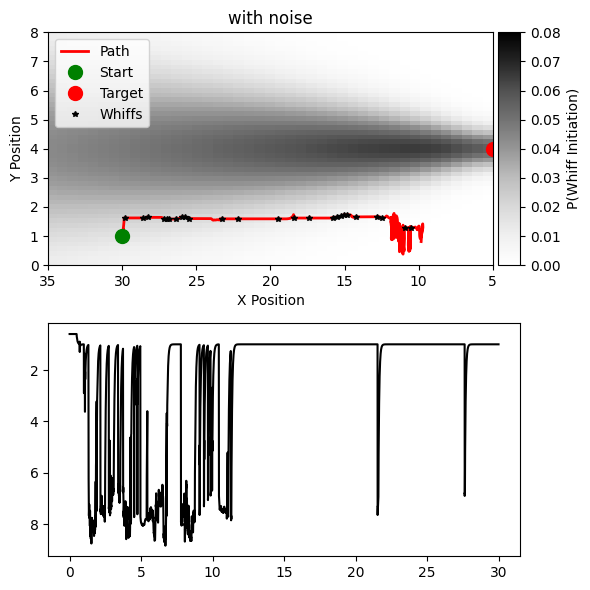

In [10]:

if __name__ == "__main__":
    # Setup simulation parameters - Now with no bounds
    bounds = None  # Remove bounds completely
    # start_pos = np.array([13.0, 6.0])  # Starting in the middle
    target_pos = np.array([5.0, 4.0])   # Target on the left side
    
    surge_agent = SurgeCastAgent(
        tau=0.1,
        noise=2.0,
        bias=0.1,         # Reduced bias since it's now purely directional
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=0.5,
        tau_surge=2.0,
        cast_freq=1.0,    # Casting frequency
        cast_width=2.0,   # Casting width
        bounds=None       # No bounds
    )
    
    # No target weight needed anymore
    # target_weight = 0
    plume_timeout = 10.0
    closest_to_source = 0.2
    sim_duration = 30.0
    dt=0.005
    
    # Load predictor data (same as in original code)
    dirname = '../data/simulator/rigolli/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

    # Create predictor 
    predictor = CosmosFast(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )
    
    # Run the tracking simulation
    # print(f"Running simulation from position {start_pos}:")
    
    # Record starting time
    start_wall = time.time()
    
    x_bounds = (25, 35)
    y_bounds = (1, 7)
    
    # Number of random starting points
    num_starting_points = 1
    
    # Generate random integer starting points within bounds
    np.random.seed(42)  # For reproducibility
    random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
    random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)

    # Run the tracking simulation
    # trajectory_df = tracking(
    #     predictor, bounds, start_pos, target_pos, surge_agent,
    #      plume_timeout, closest_to_source, sim_duration
    # )
    starting_positions = []
    for i in range(num_starting_points):
        # start_pos = np.array([float(random_x[i]), float(random_y[i])])
        start_pos=np.array([30.0, 1.0])
        print(start_pos)
        starting_positions.append(start_pos.copy())
        
        print(f"\nRunning simulation {i+50}/{str(num_starting_points)} {start_pos}:")
        
        # Record starting wall-clock time and CPU times for this iteration
        # start_wall = time.time()
        # start_cpu = os.times()
        trajectory_df=pd.DataFrame()
        # Run the tracking simulation
        trajectory_df = tracking(
            predictor, bounds, start_pos, target_pos, surge_agent,
            plume_timeout, closest_to_source, sim_duration, dt 
        )
        # trajectory_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/april3/plot_trajs/cosmos'+str(i+1)+'_40_1_60.h5', mode='w',key='trajector_df')
        
        fig, (ax,ax1) = plt.subplots(2,1,figsize=(6, 6))

        fitted_p_heatmap = hmap_data['fitted_p_heatmap']
        xedges = hmap_data['xedges']
        yedges = hmap_data['yedges']

        # Plot the heatmap with lighter blue colormap and lower max value for better contrast
        cax = ax.imshow(
            fitted_p_heatmap.T,
            origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            cmap='Greys',  # Using Blues colormap
            vmin=0, 
            vmax=0.08,    # Lower max value to make the heatmap lighter
            aspect='auto',
            alpha=1      # Make the heatmap slightly transparent
        )

        # Add colorbar
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(cax, cax=cbar_ax, label='P(Whiff Initiation)')

        # Overlay trajectory on the heatmap
        ax.plot(trajectory_df.x, trajectory_df.y, c='red', label='Path', linewidth=2)
        ax.plot(start_pos[0], start_pos[1], 'go', label='Start', markersize=10)
        ax.plot(target_pos[0], target_pos[1], 'ro', label='Target', markersize=10)

        # Plot odor detections
        whiff_rows = trajectory_df[trajectory_df.whiff == 1]
        if not whiff_rows.empty:
            ax.plot(whiff_rows.x, whiff_rows.y, 'k*', label='Whiffs', markersize=4)

        # # Set consistent bounds
        ax.set_xlim(5,35)
        # ax.set_ylim(bounds[1])

        # Add labels and title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title('with noise')
        ax.legend(loc='upper left')
        ax.grid(False)
        ax1.plot(trajectory_df.time, trajectory_df.odor, c='black')
        # Print summary
        print(f"Simulation completed in {time.time() - start_wall:.2f} seconds")
        print(f"Number of steps: {len(trajectory_df)}")
        print(f"Number of odor detections: {whiff_rows.shape[0]}")
        print(f"Final distance to target: {trajectory_df.iloc[-1]['dist_to_target']:.2f}")
        ax.invert_xaxis()
        ax1.invert_yaxis()
        plt.tight_layout()
    

In [ ]:
if __name__ == "__main__":
    # Setup simulation parameters
    bounds = None  # Remove bounds completely
    # start_pos = np.array([35.0, 1.0])  # Starting in the middle
    target_pos = np.array([5.0, 4.0])   # Target on the left side
    
    surge_agent = SurgeCastAgent(
        tau=0.1,
        noise=2.0,
        bias=0.1,         # Reduced bias since it's now purely directional
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=0.5,
        tau_surge=2.0,
        cast_freq=1.0,    # Casting frequency
        cast_width=2.0,   # Casting width
        bounds=None       # No bounds
    )
    
    
    # No target weight needed anymore
    # target_weight = 0
    plume_timeout = 10.0
    closest_to_source = 0.2
    sim_duration = 50.0
    
    # Load predictor data (same as in original code)
    dirname = '../data/simulator/rigolli/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

    # Create predictor 
    predictor = CosmosFast(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )
       

    # Define the bounds for random starting points
    x_bounds = (7, 30)
    y_bounds = (2, 6)
    
    # Number of random starting points
    num_starting_points = 5
    
    # Generate random integer starting points within bounds
    np.random.seed(42)  # For reproducibility
    random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
    random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)
    
    # Lists to store results
    wall_times = []
    cpu_times = []
    cpu_hours_list = []
    starting_positions = []
    num_steps_list = []
    norm_wall_times = []
    norm_cpu_times = []
    

    # Record starting wall-clock time and CPU times for the entire run
    start_wall_total = time.time()
    start_cpu_total = os.times()
    
    # Loop over all random starting points
    for i in range(num_starting_points):
        start_pos = np.array([float(random_x[i]), float(random_y[i])])
        print(start_pos)
        starting_positions.append(start_pos.copy())
        
        print(f"\nRunning simulation {i+1}/50 from position {start_pos}:")
        
        # Record starting wall-clock time and CPU times for this iteration
        # start_wall = time.time()
        # start_cpu = os.times()
        osdf=pd.DataFrame()
        # Run the tracking simulation
        osdf= tracking(predictor, bounds, start_pos,target_pos,surge_agent, plume_timeout, closest_to_source, sim_duration )
        
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    
        # Plot trajectory
        axs.plot(osdf.x, osdf.y, c='blue', label='Path')
        axs.plot(start_pos[0], start_pos[1], 'go', label='Start')
        axs.plot(target_pos[0], target_pos[1], 'ro', label='Target')

        whiff_rows = osdf[osdf.whiff == 1]
        if not whiff_rows.empty:
            axs.plot(whiff_rows.x, whiff_rows.y, 'g*', label='Whiffs')
        
        
        
        # osdf= tracking(predictor, bounds, start_pos,target_pos,surge_agent, plume_timeout, closest_to_source, sim_duration )
        # osdf.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/april3/os'+str(i+1)+'.h5', mode='w',key='osdf')
    
        # num_steps_taken = len(osdf)
        # # osdf.to_hdf('/home/gorilla/An/data/simulator/plot/os_gazebo.h5', mode='w', key='osdf')
        # # Record ending times
        # end_wall = time.time()
        # end_cpu = os.times()
        
        # # Calculate elapsed wall-clock time
        # wall_time_elapsed = end_wall - start_wall
        
        # # Calculate total CPU time including child processes
        # cpu_time_used = ((end_cpu.user - start_cpu.user) +
        #                 (end_cpu.system - start_cpu.system) +
        #                 (end_cpu.children_user - start_cpu.children_user) +
        #                 (end_cpu.children_system - start_cpu.children_system))
        
        # # Convert CPU time from seconds to hours
        # cpu_hours_val = cpu_time_used / 3600
        
        # norm_wall_time = wall_time_elapsed / num_steps_taken if num_steps_taken > 0 else float('nan')
        # norm_cpu_time = cpu_time_used / num_steps_taken if num_steps_taken > 0 else float('nan')
        
        # # Append results to lists (add new lists for these values)
        # wall_times.append(wall_time_elapsed)
        # cpu_times.append(cpu_time_used)
        # cpu_hours_list.append(cpu_hours_val)
        # num_steps_list.append(num_steps_taken)  # NEW
        # norm_wall_times.append(norm_wall_time)  # NEW
        # norm_cpu_times.append(norm_cpu_time)    # NEW
        
        # print('Starting position: ({}, {})'.format(random_x[i], random_y[i]))
        # print('Wall-clock time: {:.2f} seconds'.format(wall_time_elapsed))
        # print('Total CPU time: {:.2f} seconds'.format(cpu_time_used))
        # print('Total CPU hours: {:.4f} hours'.format(cpu_hours_val))
    
    # # Record ending times for the entire run
    # end_wall_total = time.time()
    # end_cpu_total = os.times()
    
    # # Calculate total elapsed times
    # total_wall_time = end_wall_total - start_wall_total
    # total_cpu_time = ((end_cpu_total.user - start_cpu_total.user) +
    #                   (end_cpu_total.system - start_cpu_total.system) +
    #                   (end_cpu_total.children_user - start_cpu_total.children_user) +
    #                   (end_cpu_total.children_system - start_cpu_total.children_system))
    # total_cpu_hours = total_cpu_time / 3600
    
    # print("\nOverall Performance:")
    # print('Total wall-clock time: {:.2f} seconds'.format(total_wall_time))
    # print('Total CPU time: {:.2f} seconds'.format(total_cpu_time))
    # print('Total CPU hours: {:.4f} hours'.format(total_cpu_hours))
    
    # # Create a DataFrame with all the results
    # time_df = pd.DataFrame({
    #     'start_x': random_x,
    #     'start_y': random_y,
    #     'wall_time_s': wall_times,
    #     'cpu_time_s': cpu_times,
    #     'cpu_hours': cpu_hours_list,
    #     'num_steps': num_steps_list,               # NEW
    #     'norm_wall_time_s': norm_wall_times,       # NEW
    #     'norm_cpu_time_s': norm_cpu_times          # NEW
    # })
    
    # Save the results
    # time_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/random_starts_time.h5', mode='w', key='time_df')
    # Uncomment the line above to save the results

    # start=time.time()
    # for i in range(1):
    #     osdf=pd.DataFrame()
    #     osdf= tracking(predictor, bounds, start_pos,target_pos,surge_agent, plume_timeout, closest_to_source, sim_duration )
    #     osdf.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/os'+str(i+1)+'.h5', mode='w',key='osdf')
    # time_taken_osdf = time.time()-start
    # print('time_taken_osdf:', time_taken_osdf)

# time_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cosmos_time_mar17.h5', mode='w',key='time_df')

In [ ]:
# trajectory_df.to_hdf('/home/gorilla/An/data/simulator/plot/os_gazebo_2.h5', mode='w',key='trajectory_df')
# trajectory_df=osdf.copy()


### Rigolli Tracker

In [13]:
class CfdOdorPredictor:
    def __init__(self, cfd_simulator, scale_data_fn):
        self.cfd = cfd_simulator
        self.scale_data = scale_data_fn
        self.config = type('Config', (), {
            'warmup_steps': 0,
            'rows_per_second': 200
        })()

    def get_wind_at_position(self, pos: Tuple[float, float], time: float) -> Tuple[float, float, float]:
        return self.cfd.get_wind_at_position_and_time(pos, time)

    def get_odor_at_position(self, pos: Tuple[float, float], time: float) -> float:
        odor = self.cfd.get_odor_at_position_and_time(pos, time)
        return odor


def scale_data(data):
    min_val = 0
    max_val = 16
    return (((data - min_val) / (max_val - min_val)) * 10)


In [14]:
def cfd_tracking(
    cfd_predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    plume_timeout,
    closest_to_source,
    duration,
    dt
):
    dt = dt
    n_steps = int(duration / dt)

    # Source coordinates
    source_x = target_pos[0]
    source_y = target_pos[1]

    # This will become True once we decide we've "passed" the source
    passed_source = False
    
    # Casting delay
    casting_delay = 1.0

    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    xs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps)

    velocities = np.zeros((n_steps, 2))
    speeds = np.zeros(n_steps)
    accelerations = np.zeros(n_steps)
    angles = np.zeros(n_steps)
    angular_velocities = np.zeros(n_steps)
    crosswind_distances = np.zeros(n_steps)
    upwind_distances = np.zeros(n_steps)
    dist_to_targets = np.zeros(n_steps)
    time_since_last_hits = np.zeros(n_steps)
    casting_phases = np.zeros(n_steps)
    local_curvatures = np.zeros(n_steps)
    is_casting = np.zeros(n_steps)
    is_surging = np.zeros(n_steps)
    in_odor = np.zeros(n_steps)

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = 0.0
    last_odor = 0.0
    hit_occurred = False
    prev_angle = 0.0
    
    # Pure upwind initial bias
    upwind = np.array([-1.0, 0.0])
    b = upwind * surge_agent.bias

    for t_ctr in range(n_steps):
        # 1) Get odor from CFD predictor
        raw_odor = cfd_predictor.get_odor_at_position(tuple(x), ts[t_ctr])
        current_odor = cfd_predictor.scale_data(raw_odor)

        # 2) Check if we've passed the source (adjust logic if wind flows differently)
        if x[0] <= source_x:
            passed_source = True

        # 3) Force the odor to zero once passed_source == True
        if passed_source:
            current_odor = 0.0
        
        # Store final odor value (possibly forced to zero)
        odors[t_ctr] = current_odor

        # 4) Now define whether we're in odor
        currently_in_odor = (current_odor >= surge_agent.threshold)
        in_odor[t_ctr] = 1 if currently_in_odor else 0
        
        # Update last_hit_time if in odor
        if currently_in_odor:
            last_hit_time = t_ctr * dt

        # 5) Whiff detection (skip if passed_source == True, because odor=0)
        if not passed_source:
            if surge_agent.hit_trigger == 'peak':
                if currently_in_odor:
                    if (current_odor <= last_odor) and (not hit_occurred):
                        hits[t_ctr] = 1
                        hit_occurred = True
                    last_odor = current_odor
                else:
                    last_odor = 0
                    hit_occurred = False
            elif surge_agent.hit_trigger == 'threshold':
                hits[t_ctr] = 1 if currently_in_odor else 0

        if t_ctr > 0:
            # Noise
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = t_ctr * dt - last_hit_time
            time_since_last_hits[t_ctr] = time_since_hit

            # Distance to target
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break

            # Behavior selection
            if currently_in_odor:
                upwind_dir = np.array([-1.0, 0.0])
                surge_strength = surge_agent.surge_amp * 5.0
                v = upwind_dir * surge_strength
                # Optionally add noise
                v += eta * dt

                is_surging[t_ctr] = 1
                is_casting[t_ctr] = 0

                x += v * dt

            elif time_since_hit > casting_delay:
                cast_freq = surge_agent.cast_freq
                cast_phase = np.sin(2 * np.pi * cast_freq * ts[t_ctr])
                casting_phases[t_ctr] = cast_phase

                cast_width_factor = min(6.0, 1.0 + 0.8*(time_since_hit / plume_timeout))
                cast_width = surge_agent.cast_width * cast_width_factor

                crosswind = np.array([0.0, cast_phase * cast_width])
                upwind = np.array([-0.1, 0.0])
                
                b = upwind + crosswind
                is_casting[t_ctr] = 1
                is_surging[t_ctr] = 0

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            else:
                surge_decay = max(0.1, 1.0 - (time_since_hit / casting_delay))
                surge_direction = np.array([-1.0, 0.0])
                b = surge_direction * surge_agent.bias * 3.0 * surge_decay

                is_casting[t_ctr] = 0
                is_surging[t_ctr] = 1

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            # Reflect if bounds exist
            if bounds is not None:
                v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 1:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr - 1]) / dt
            
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            angle_diff = np.arctan2(
                np.sin(current_angle - prev_angle),
                np.cos(current_angle - prev_angle)
            )
            angular_velocities[t_ctr] = angle_diff / dt
            prev_angle = current_angle
            
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target

            if t_ctr >= 2:
                pos_window = xs[t_ctr - 2 : t_ctr + 1]
                dx = np.gradient(pos_window[:, 0])
                dy = np.gradient(pos_window[:, 1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                denom = (dx**2 + dy**2)**1.5 + 1e-10
                curvature = np.abs(dx*ddy - dy*ddx) / denom
                local_curvatures[t_ctr] = np.mean(curvature)

        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim if ended early
    if t_ctr < (n_steps - 1):
        trim_slice = slice(0, t_ctr + 1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        odors = odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]
        is_casting = is_casting[trim_slice]
        is_surging = is_surging[trim_slice]
        in_odor = in_odor[trim_slice]

    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:, 0],
        'y': xs[:, 1],
        'vx': velocities[:, 0],
        'vy': velocities[:, 1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'is_casting': is_casting,
        'is_surging': is_surging,
        'odor': odors,
        'whiff': hits,
        'in_odor': in_odor,
        'bias_force_x': bs[:, 0],
        'bias_force_y': bs[:, 1]
    })

    # Remove final row if it's exactly x=y=0
    if len(trajectory_df) > 0 \
       and trajectory_df.iloc[-1]['x'] == 0 \
       and trajectory_df.iloc[-1]['y'] == 0:
        trajectory_df = trajectory_df.iloc[:-1]
    return trajectory_df


Running simulation 50/1 from position [30.  1.]:
Simulation completed in 17.84 seconds
Number of steps: 2400
Number of odor detections: 43
Final distance to target: 3.21


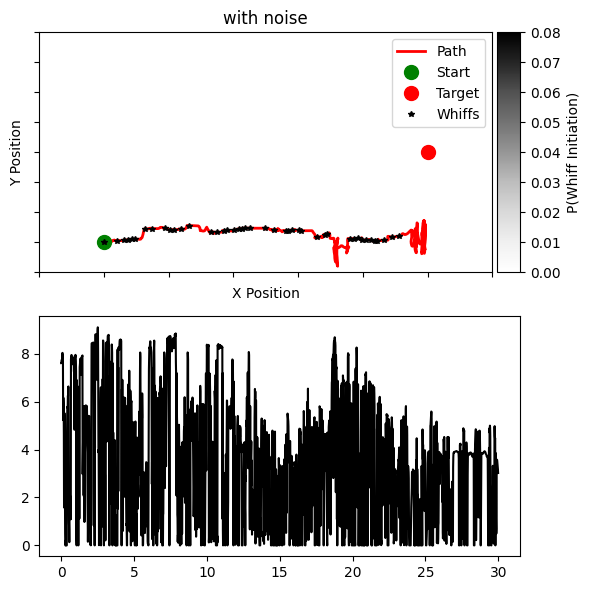

In [19]:
bounds = None
# start_pos = np.array([20.0, 6.0])

target_pos = np.array([5.0, 4.0])

# Create surge-cast agent
surge_agent = SurgeCastAgent(
    tau=0.1,
    noise=2.0,
    bias=0.1,         # Reduced bias since it's now purely directional
    threshold=6.5,
    hit_trigger='peak',
    surge_amp=0.5,
    tau_surge=2.0,
    cast_freq=1.0,    # Casting frequency
    cast_width=2.0,   # Casting width
    bounds=None       # No bounds
)

target_weight = 0
plume_timeout = 10.0
closest_to_source = 0.2
sim_duration = 30.0

# Define the bounds for random starting points
x_bounds = (25, 35)
y_bounds = (1, 7)
dt=0.0125
# Number of random starting points
num_starting_points = 1

# Generate random integer starting points within bounds
np.random.seed(42)  # For reproducibility
random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)

# Lists to store results
wall_times = []
cpu_times = []
cpu_hours_list = []
starting_positions = []

# Record starting wall-clock time and CPU times for the entire run
start_wall_total = time.time()
start_cpu_total = os.times()

# Loop over all random starting points
for i in range(num_starting_points):
    # start_pos = np.array([float(random_x[i]), float(random_y[i])])
    start_pos=np.array([30.0, 1.0])
    starting_positions.append(start_pos.copy())
    
    print(f"\nRunning simulation {i+50}/{str(num_starting_points)} from position {start_pos}:")
    new_cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
    cfd_predictor = CfdOdorPredictor(new_cfd, scale_data)
    
    # Record starting wall-clock time and CPU times for this iteration
    start_wall = time.time()
    start_cpu = os.times()
    
    # Run the CFD tracking simulation
    cfd_df = cfd_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent,
                           plume_timeout, closest_to_source, sim_duration,dt)
    
    # cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/april3/plot_trajs/cfd'+str(i+1)+'_40_1_60.h5', mode='w',key='cfd_df')
        
# # Record ending times

    fig, (ax,ax1) = plt.subplots(2,1,figsize=(6, 6))


    # fitted_p_heatmap = hmap_data['fitted_p_heatmap']
    # xedges = hmap_data['xedges']
    # yedges = hmap_data['yedges']

    # Plot the heatmap with lighter blue colormap and lower max value for better contrast
    # cax = ax.imshow(
    #     fitted_p_heatmap.T,
    #     origin='lower',
    #     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    #     cmap='Blues',  # Using Blues colormap
    #     vmin=0, 
    #     vmax=0.08,    # Lower max value to make the heatmap lighter
    #     aspect='auto',
    #     alpha=1      # Make the heatmap slightly transparent
    # )

    # Add colorbar
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax, cax=cbar_ax, label='P(Whiff Initiation)')

    # Overlay trajectory on the heatmap
    ax.plot(cfd_df.x, cfd_df.y, c='red', label='Path', linewidth=2)
    ax.plot(start_pos[0], start_pos[1], 'go', label='Start', markersize=10)
    ax.plot(target_pos[0], target_pos[1], 'ro', label='Target', markersize=10)

    # Plot odor detections
    whiff_rows = cfd_df[cfd_df.whiff == 1]
    if not whiff_rows.empty:
        ax.plot(whiff_rows.x, whiff_rows.y, 'k*', label='Whiffs', markersize=4)

    # # Set consistent bounds
    # ax.set_xlim(bounds[0])
    # ax.set_ylim(bounds[1])

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('with noise')
    ax.legend(loc='upper right')
    ax.grid(False)
    ax1.plot(cfd_df.time,cfd_df.odor, c='black')
    ax.set_xlim(0,35)
    ax.set_ylim(0,8)
    ax.invert_xaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Print summary
    print(f"Simulation completed in {time.time() - start_wall:.2f} seconds")
    print(f"Number of steps: {len(cfd_df)}")
    print(f"Number of odor detections: {whiff_rows.shape[0]}")
    print(f"Final distance to target: {cfd_df.iloc[-1]['dist_to_target']:.2f}")

    fig.tight_layout()


In [ ]:
# cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
# cfd_predictor = CfdOdorPredictor(cfd, scale_data)
bounds = [(5, 40), (0, 8)]
# start_pos = np.array([20.0, 6.0])

target_pos = np.array([5.0, 4.0])

# Create surge-cast agent
surge_agent = SurgeCastAgent(
    tau=0.3,
    noise=3.0,
    bias=0.1,
    threshold=6.5,
    hit_trigger='peak',
    surge_amp=1.5,
    tau_surge=1.0,
    bounds=bounds
)

target_weight = 0
plume_timeout = 10.0
closest_to_source = 0.2
sim_duration = 100.0

# Define the bounds for random starting points
x_bounds = (7, 30)
y_bounds = (3, 5)

# Number of random starting points
num_starting_points = 1

# Generate random integer starting points within bounds
np.random.seed(42)  # For reproducibility
random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)

# Lists to store results
wall_times = []
cpu_times = []
cpu_hours_list = []
starting_positions = []
num_steps_list = []
norm_wall_times = []
norm_cpu_times = []

# Record starting wall-clock time and CPU times for the entire run
start_wall_total = time.time()
start_cpu_total = os.times()

# Loop over all random starting points
for i in range(num_starting_points):
    start_pos = np.array([float(random_x[i]), float(random_y[i])])
    starting_positions.append(start_pos.copy())
    
    print(f"\nRunning simulation {i+1}/50 from position {start_pos}:")
    new_cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
    cfd_predictor = CfdOdorPredictor(new_cfd, scale_data)
    
    # Record starting wall-clock time and CPU times for this iteration
    start_wall = time.time()
    start_cpu = os.times()
    
    # Run the CFD tracking simulation
    cfd_df = cfd_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent,
                          target_weight, plume_timeout, closest_to_source, sim_duration)
    
    num_steps_taken = len(cfd_df)
    # Record ending times
    end_wall = time.time()
    end_cpu = os.times()
    
    # Calculate elapsed wall-clock time
    wall_time_elapsed = end_wall - start_wall
    
    # Calculate total CPU time including child processes
    cpu_time_used = ((end_cpu.user - start_cpu.user) +
                     (end_cpu.system - start_cpu.system) +
                     (end_cpu.children_user - start_cpu.children_user) +
                     (end_cpu.children_system - start_cpu.children_system))
    
    # Convert CPU time from seconds to hours
    cpu_hours_val = cpu_time_used / 3600
    

    norm_wall_time = wall_time_elapsed / num_steps_taken if num_steps_taken > 0 else float('nan')
    norm_cpu_time = cpu_time_used / num_steps_taken if num_steps_taken > 0 else float('nan')
    
    # Append results to lists (add new lists for these values)
    wall_times.append(wall_time_elapsed)
    cpu_times.append(cpu_time_used)
    cpu_hours_list.append(cpu_hours_val)
    num_steps_list.append(num_steps_taken)  # NEW
    norm_wall_times.append(norm_wall_time)  # NEW
    norm_cpu_times.append(norm_cpu_time)  
    
    print('Starting position: ({}, {})'.format(random_x[i], random_y[i]))
    print('Wall-clock time: {:.2f} seconds'.format(wall_time_elapsed))
    print('Total CPU time: {:.2f} seconds'.format(cpu_time_used))
    print('Total CPU hours: {:.4f} hours'.format(cpu_hours_val))

# Record ending times for the entire run
end_wall_total = time.time()
end_cpu_total = os.times()

# Calculate total elapsed times
total_wall_time = end_wall_total - start_wall_total
total_cpu_time = ((end_cpu_total.user - start_cpu_total.user) +
                  (end_cpu_total.system - start_cpu_total.system) +
                  (end_cpu_total.children_user - start_cpu_total.children_user) +
                  (end_cpu_total.children_system - start_cpu_total.children_system))
total_cpu_hours = total_cpu_time / 3600

print("\nOverall Performance:")
print('Total wall-clock time: {:.2f} seconds'.format(total_wall_time))
print('Total CPU time: {:.2f} seconds'.format(total_cpu_time))
print('Total CPU hours: {:.4f} hours'.format(total_cpu_hours))

# Create a DataFrame with all the results
cfd_time = pd.DataFrame({
    'start_x': random_x,
    'start_y': random_y,
    'wall_time_s': wall_times,
    'cpu_time_s': cpu_times,
    'cpu_hours': cpu_hours_list,
    'num_steps': num_steps_list,               # NEW
    'norm_wall_time_s': norm_wall_times,       # NEW
    'norm_cpu_time_s': norm_cpu_times          # NEW
})

# start=time.time()
# for i in range(1):
#     # cfd_df=pd.DataFrame()
#     cfd_df = cfd_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent, 
#                           target_weight, plume_timeout, closest_to_source, sim_duration)
#     # cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/feb28/cfd'+str(i+1)+'.h5', mode='w',key='osdf')

# time_taken_cfd = time.time()-start
# print('time_taken_cfd:', time_taken_cfd)
# cfd_time.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cfd_bstrap_time_mar17.h5', mode='w',key='cfd_time')



Running simulation 1/50 from position [13.  3.]:
Starting position: (13, 3)
Wall-clock time: 59.79 seconds
Total CPU time: 82.15 seconds
Total CPU hours: 0.0228 hours

Overall Performance:
Total wall-clock time: 60.11 seconds
Total CPU time: 82.47 seconds
Total CPU hours: 0.0229 hours


In [47]:
cot_df=pd.read_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/timing/cosmos_time_mar17.h5')
cft_df=pd.read_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/timing/cfd_bstrap_time_mar17.h5')

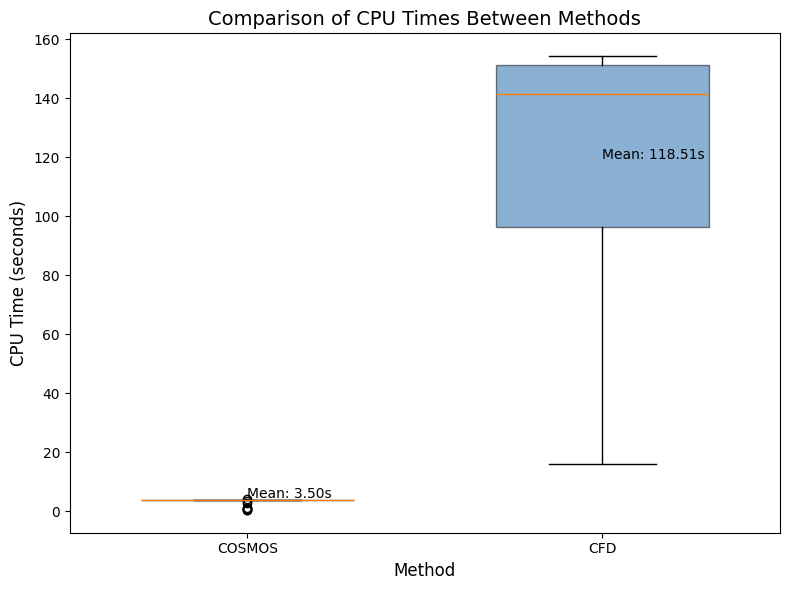

In [48]:

stat_model_times = cot_df['cpu_time_s'].values[:-1]
cfd_model_times = cft_df['cpu_time_s'].values[:-1]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxplot = ax.boxplot(
    [stat_model_times, cfd_model_times], 
    labels=['COSMOS', 'CFD'],
    patch_artist=True,
    widths=0.6
)

# Customize the boxplot colors
colors = ['#bc141a', '#1764ab']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add title and labels
ax.set_title('Comparison of CPU Times Between Methods', fontsize=14)
ax.set_ylabel('CPU Time (seconds)', fontsize=12)
ax.set_xlabel('Method', fontsize=12)

ax.grid(False)
mean_stat = np.mean(stat_model_times)
mean_cfd = np.mean(cfd_model_times)
ax.text(1, mean_stat, f'Mean: {mean_stat:.2f}s', verticalalignment='bottom', fontsize=10)
ax.text(2, mean_cfd, f'Mean: {mean_cfd:.2f}s', verticalalignment='bottom', fontsize=10)

fig.tight_layout()


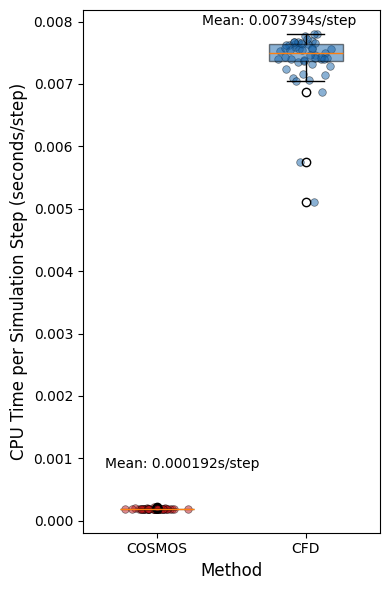

In [67]:
# Update your plotting code to use normalized times
stat_model_norm_times = cot_df['norm_cpu_time_s'].values[:-1]
cfd_model_norm_times = cft_df['norm_cpu_time_s'].values[:-1]

fig, ax = plt.subplots(figsize=(4, 6))

# Create the boxplot
boxplot = ax.boxplot(
    [stat_model_norm_times, cfd_model_norm_times],
    labels=['COSMOS', 'CFD'],
    patch_artist=True,
    widths=0.5
)

# Customize the boxplot colors
colors = ['#bc141a', '#1764ab']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

# Add individual points with jitter
for i, data in enumerate([stat_model_norm_times, cfd_model_norm_times]):
    # Add jitter to x position
    x = np.random.normal(i+1, 0.08, size=len(data))
    ax.scatter(x, data, alpha=0.5, s=30, c=colors[i], edgecolor='k', linewidth=0.5)

# Add grid lines for readability
# ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.grid(False)

# Add title and labels
# ax.set_title('Comparison of Normalized\nCPU Times Between Methods', fontsize=14)
ax.set_ylabel('CPU Time per Simulation Step (seconds/step)', fontsize=12)
ax.set_xlabel('Method', fontsize=12)

# Add mean values
mean_stat_norm = np.mean(stat_model_norm_times)
mean_cfd_norm = np.mean(cfd_model_norm_times)
ax.text(0.65,0.0008, f'Mean: {mean_stat_norm:.6f}s/step', 
        verticalalignment='bottom', fontsize=10)
ax.text(1.3, 0.0079, f'Mean: {mean_cfd_norm:.6f}s/step', 
        verticalalignment='bottom', fontsize=10)

fig.tight_layout()

In [257]:
# cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/cfd8.h5', mode='w',key='cfd_df')

In [70]:
cfd_old = Cfd_rigolli(dirname="../data/rigolli/")
cfd_new = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
df=pd.read_hdf('/home/gorilla/An/data/simulator/rigolli/rigolli_jan22.h5')

In [71]:
s=100000
e=105000
# plt.scatter(df.distance_along_streakline[s:e], df.nearest_from_streakline[s:e])

In [41]:
start=time.time()
odor_old = []
for i in range(len(df[s:e])):
    odor_old.append(cfd_old.get_odor_at_position_and_time((df.distance_along_streakline[i],df.nearest_from_streakline[i]),20))
time_taken_old = time.time()-start
print('time_taken_old:', time_taken_old)

time_taken_old: 57.50307512283325


BDCATS

In [72]:
start=time.time()
odor_new = []
for i in range(len(df[s:e])):
    odor_new.append(cfd_new.get_odor_at_position_and_time((df.distance_along_streakline[i],df.nearest_from_streakline[i]),20))
time_taken_new = time.time()-start
print('time_taken_new:', time_taken_new)

time_taken_new: 0.5815508365631104


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

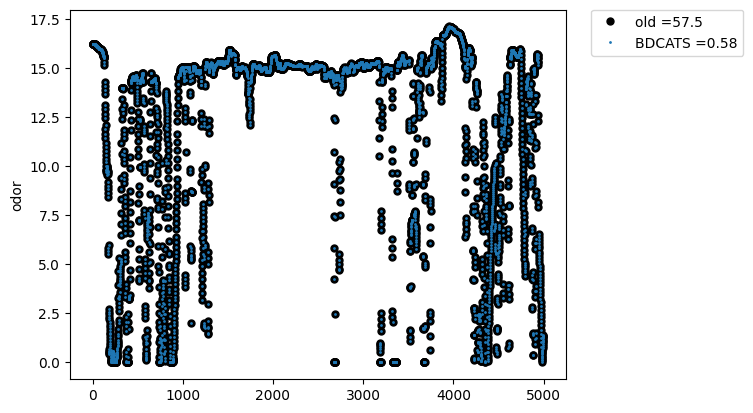

In [73]:
plt.plot(odor_old, 'o', markersize=5, label='old =' + str(round(time_taken_old, 2)), c='black')
plt.plot(odor_new, 'o', markersize=1, label='BDCATS =' + str(round(time_taken_new, 2)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('odor')
plt.plot

=== Performance Comparison ===
Original method: 57.74s, Peak memory: 6355.10 MB
BD-CATS method: 0.74s, Peak memory: 6370.88 MB
Speedup: 78.30x
Memory efficiency: 1.00x


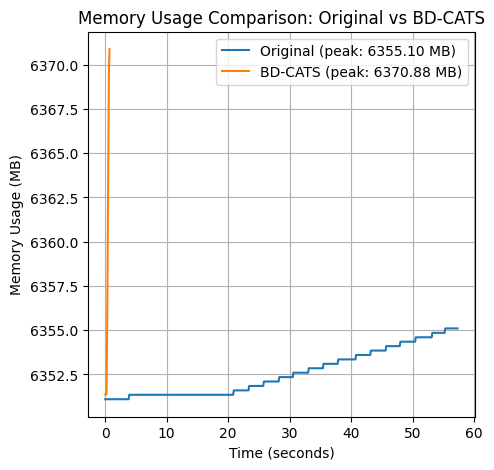


=== Memory Usage Breakdown ===
Top 10 types using memory before BD-CATS initialization:
dict                       199121
function                   158463
list                       118238
tuple                      113125
cell                       50482
ReferenceType              40220
memoryview                 39216
Parameter                  37783
builtin_function_or_method 30005
Name                       23332

Top 10 types after BD-CATS usage:
dict                       198144
function                   158209
list                       117642
tuple                      112800
cell                       50472
ReferenceType              39987
memoryview                 39216
Parameter                  37783
builtin_function_or_method 29770
Name                       23332

Object growth during BD-CATS usage:
tuple             112791       +51
dict              198145       +51
FontProperties      2328       +44
ReferenceType      39987       +11
list              117640       

In [ ]:

from memory_profiler import profile, memory_usage
import matplotlib.pyplot as plt

def compare_memory_usage(original_cfd, bdcats_cfd, df, s, e, time_value):
    """
    Compare memory usage between original CFD implementation and BD-CATS version.
    """
    # Create list of test positions from dataframe
    test_positions = [(df.distance_along_streakline[i], df.nearest_from_streakline[i]) for i in range(s, e)]
    
    # Define functions to profile
    def original_method():
        results = []
        for pos in test_positions:
            results.append(original_cfd.get_odor_at_position_and_time(pos, time_value))
        return results
    
    def bdcats_method():
        results = []
        for pos in test_positions:
            results.append(bdcats_cfd.get_odor_at_position_and_time(pos, time_value))
        return results
    
    # Track time for original method
    start_time = time.time()
    original_mem = memory_usage((original_method, [], {}), interval=0.1)
    original_time = time.time() - start_time
    
    # Track time for BD-CATS method
    start_time = time.time()
    bdcats_mem = memory_usage((bdcats_method, [], {}), interval=0.1)
    bdcats_time = time.time() - start_time
    
    # Calculate metrics
    results = {
        'original': {
            'time': original_time,
            'memory_profile': original_mem,
            'peak_memory': max(original_mem),
            'avg_memory': sum(original_mem) / len(original_mem)
        },
        'bdcats': {
            'time': bdcats_time,
            'memory_profile': bdcats_mem,
            'peak_memory': max(bdcats_mem),
            'avg_memory': sum(bdcats_mem) / len(bdcats_mem)
        },
        'comparison': {
            'time_speedup': original_time / bdcats_time,
            'memory_ratio': max(original_mem) / max(bdcats_mem)
        }
    }
    
    return results

# Create instances of both classes
original_cfd = Cfd_rigolli(dirname="../data/rigolli/")
bdcats_cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")

df=pd.read_hdf('/home/gorilla/An/data/simulator/rigolli/rigolli_jan22.h5')

# Run the comparison using your dataframe data
results = compare_memory_usage(original_cfd, bdcats_cfd, df, s, e, time_value=20)

# Print summary
print(f"=== Performance Comparison ===")
print(f"Original method: {results['original']['time']:.2f}s, Peak memory: {results['original']['peak_memory']:.2f} MB")
print(f"BD-CATS method: {results['bdcats']['time']:.2f}s, Peak memory: {results['bdcats']['peak_memory']:.2f} MB")
print(f"Speedup: {results['comparison']['time_speedup']:.2f}x")
print(f"Memory efficiency: {results['comparison']['memory_ratio']:.2f}x")

# Plot memory usage over time
plt.figure(figsize=(5, 5))
time_points_original = np.arange(0, len(results['original']['memory_profile']) * 0.1, 0.1)
time_points_bdcats = np.arange(0, len(results['bdcats']['memory_profile']) * 0.1, 0.1)

plt.plot(time_points_original, results['original']['memory_profile'], 
         label=f"Original (peak: {results['original']['peak_memory']:.2f} MB)")
plt.plot(time_points_bdcats, results['bdcats']['memory_profile'], 
         label=f"BD-CATS (peak: {results['bdcats']['peak_memory']:.2f} MB)")

plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison: Original vs BD-CATS')
plt.legend()
plt.show()

# For a detailed investigation of where memory is being used
print("\n=== Memory Usage Breakdown ===")
try:
    import objgraph
    print("Top 10 types using memory before BD-CATS initialization:")
    objgraph.show_most_common_types(limit=10)
    
    # Force some garbage collection
    import gc
    gc.collect()
    
    # Run a short test with the BD-CATS method
    bdcats_test_results = bdcats_cfd.get_odor_at_position_and_time((20, 5), 20)
    
    print("\nTop 10 types after BD-CATS usage:")
    objgraph.show_most_common_types(limit=10)
    
    print("\nObject growth during BD-CATS usage:")
    objgraph.show_growth()
except ImportError:
    print("objgraph not installed. Run 'pip install objgraph' for detailed object tracking.")